In [0]:
!pip install -q kaggle

In [6]:
import json
import os
import gzip
import io
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


In [13]:
!ls -r
!rm -rf 'kaggle (1).json'

 sample_data   kaggle.json  'kaggle (1).json'


In [0]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [15]:
!kaggle competitions download -c competitive-data-science-predict-future-sales -p '../input/'

  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.38MB/s]
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 49.1MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.76MB/s]
  0% 0.00/469k [00:00<?, ?B/s]
100% 469k/469k [00:00<00:00, 152MB/s]
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 143MB/s]
 39% 5.00M/12.9M [00:00<00:00, 45.8MB/s]
100% 12.9M/12.9M [00:00<00:00, 63.1MB/s]


In [16]:
!gunzip "../input/sales_train.csv.gz"
!gunzip "../input/test.csv.gz"
!gunzip "../input/sample_submission.csv.gz"

print(os.listdir("/input"))

['item_categories.csv', 'sample_submission.csv', 'test.csv', 'items.csv', 'sales_train.csv', 'shops.csv']


In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import holidays
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import re
import seaborn as sns
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['item_categories.csv', 'sample_submission.csv', 'test.csv', 'items.csv', 'sales_train.csv', 'shops.csv']


In [0]:
categories_data=pd.read_csv("../input/item_categories.csv")
items_data=pd.read_csv("../input/items.csv")
shops_data=pd.read_csv("../input/shops.csv")
train=pd.read_csv("../input/sales_train.csv")
test=pd.read_csv("../input/test.csv")

In [34]:
categories_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [35]:
categories_data['item_category']=categories_data.item_category_name.apply(lambda x: x.split('-')[0])
categories_data['item_sub_category']=categories_data.item_category_name.apply(lambda x: x.split('-')[1] if (x.count('-')>0) else x)
categories_data.head()

,item_category_name,item_category_id,item_category,item_sub_category
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,Аксессуары,PS2
2,Аксессуары - PS3,2,Аксессуары,PS3
3,Аксессуары - PS4,3,Аксессуары,PS4
4,Аксессуары - PSP,4,Аксессуары,PSP


In [21]:
categories_data.shape

(84, 4)

In [0]:
shops_data['shop_name_mod']=shops_data.shop_name.apply(lambda x: re.sub('[!@#$%^&*(),.?":{}|<>]','',x))
shops_data['city_name']=shops_data.shop_name.apply(lambda x: x.split(' ')[0])

In [25]:
shops_data.head()

,shop_name,shop_id,shop_name_mod,city_name
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск Орджоникидзе 56 фран,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск ТЦ Центральный фран,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея ТЦ Мега,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха ТРК Октябрь-Киномир,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский ТЦ Волга Молл,Волжский


In [36]:
train.shape

(2935849, 6)

In [57]:
train.loc[train.item_cnt_day <0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_Returned
2,05.01.2013,0,25,2552,899.0,-1.0,1
148,23.01.2013,0,25,2321,999.0,-1.0,1
175,07.01.2013,0,25,2199,1449.0,-1.0,1
807,02.01.2013,0,25,2330,599.0,-1.0,1
1041,13.01.2013,0,25,5034,1989.0,-1.0,1


In [0]:
train['is_Returned']=train.item_cnt_day.apply(lambda x: "1" if (x<0) else "0")

In [39]:
train.loc[train.item_price <0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,is_Returned
484683,15.05.2013,4,32,2973,-1.0,1.0,0


In [45]:
items_data[items_data['item_id']==2973]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


In [55]:
test.loc[test.item_id ==2973].count()

ID         0
shop_id    0
item_id    0
dtype: int64

In [0]:
train['is_Complementry']=train.item_price.apply(lambda x: "1" if (x<0) else "0")

In [60]:
items_category_data=items_data.merge(categories_data,how='inner',on='item_category_id')
items_category_data.head()

,item_name,item_id,item_category_id,item_category_name,item_category,item_sub_category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD


In [71]:
items_category_data=items_data.merge(categories_data,how='inner',on='item_category_id')
items_category_data['item_name_mod']=items_category_data.item_name.apply(lambda x: re.sub('[!@#$%^&*(),.?":{}|<>]','',x))
items_category_data.head()

,item_name,item_id,item_category_id,item_category_name,item_category,item_sub_category,item_name_mod
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,DVD,ВО ВЛАСТИ НАВАЖДЕНИЯ ПЛАСТ D
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,DVD,В ЛУЧАХ СЛАВЫ UNV D
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,DVD,ГОЛУБАЯ ВОЛНА Univ D
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,DVD,КОРОБКА СТЕКЛО D
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,DVD,НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ UNI D


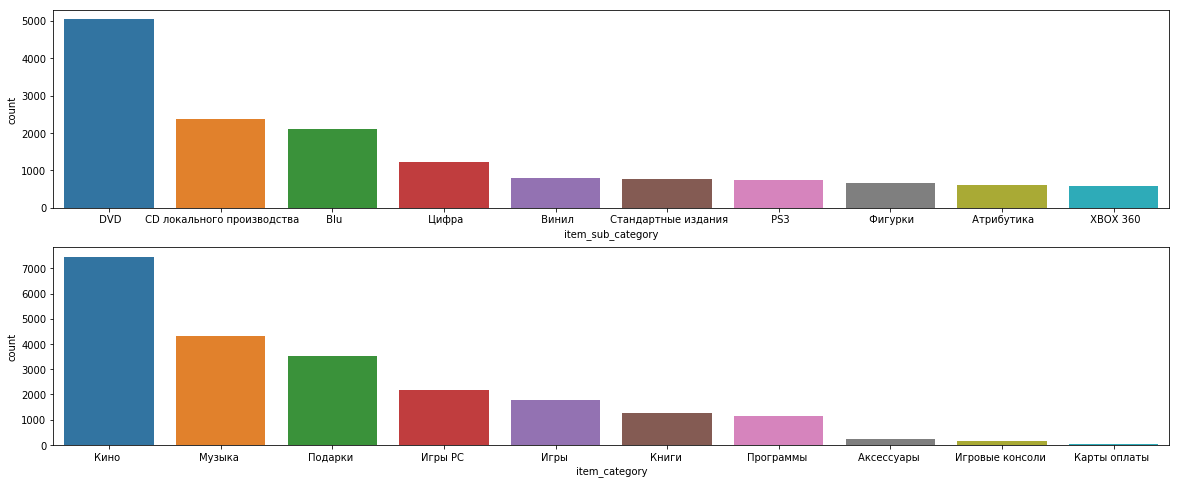

In [79]:
#items_category_data.item_sub_category.plot(kind='bar')
fig, axarr = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(x='item_sub_category',data=items_category_data,order=items_category_data.item_sub_category.value_counts().iloc[:10].index,ax=axarr[0])
sns.countplot(x='item_category',data=items_category_data,order=items_category_data.item_category.value_counts().iloc[:10].index,ax=axarr[1])

65

In [42]:
#Label Encode item_category	item_sub_category
item_category_le = preprocessing.LabelEncoder()
item_category_le.fit(items_data.item)

item_category_le.transform([1, 1, 2, 6]) 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [0]:
train=train.merge(items_category_data,how='inner',on='item_id')
train=train.merge(shops_data,how='inner',on='shop_id')

train.head()

In [0]:
#train.drop(['item_id','item_category_id'],inplace=True,axis=1)

In [0]:
train.head()

In [0]:
train.isnull().sum()

In [0]:
train.sort_values(by=['date'],inplace=True)

In [0]:
train['day_of_Week']=train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%A'))

In [0]:
train['week_num']=train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%V'))

In [0]:
russian_holidays=holidays.Russia(years = [2013,2014])
for ptr in russian_holidays.items(): 
    print(ptr)

min(train.date),max(train.date)
#min(test.date),max(test.date)

In [0]:
train['is_holiday']=train.date.apply(lambda x: True if (x in russian_holidays) else False )

In [0]:
train.head()

In [0]:
train_clean=train.groupby(['shop_id','item_cnt_day']).sum().reset_index()

In [0]:
train_clean.head()

In [0]:
train.shop_id.value_counts(sort=True)[:10].plot(kind='bar')

In [0]:
sns.countplot(x='item_id',data=train,order=train.item_id.value_counts().iloc[:10].index)

In [0]:
sns.countplot(x='week_num',data=train,order=train.loc[train.item_id==5037].week_num.value_counts().iloc[:10].index)


In [0]:
#sns.boxplot(x='week_num',y='item_price',data=train.loc[train.item_id==5037])
data=train.query('item_id == 7856 and shop_id in (31,25,54,28,57,42,27,6,58,56)')
#data.sort_values(by=['week_num']).head()
g=sns.relplot(x='week_num',y='item_price',hue='is_holiday',col='shop_id',
            data=data.sort_values(by=['week_num']),col_wrap=1,aspect=2)

In [0]:
sns.countplot(x='item_cnt_day',data=train_clean,order=train_clean.shop_id.value_counts().iloc[:10].index)

In [0]:
train_clean.head()

In [0]:
data=train.query('item_id == 3876 and shop_id in (31,25)')
data=data.iloc[:,[1,2,3,4,5,13]].groupby(['shop_id','item_id']).mean().reset_index()
data.loc[data.shop_id==31]
#sns.boxplot(x=data.item_price)

In [0]:
train.query('item_id == 3876 and shop_id==31 and date_block_num==8')

In [0]:
train_data_grouped_shopid=[]
train_data_grouped_shopid=train.iloc[:,[2,3,4,13]].groupby(["shop_id","item_id"]).mean().reset_index()
#train['mean_price_shopid_itemid']=().iloc['item_price']
train_data_grouped_shopid.rename(columns={"item_price":"item_meanprice_weeknum"},inplace=True)
train_data_grouped_shopid.head()
#

In [0]:
#train.drop('item_meanprice_weeknum',axis=1,inplace=True)
#train.drop('item_meanprice_weeknum_y',axis=1,inplace=True)

In [0]:
train.head()

In [0]:
train=train.merge(train_data_grouped_shopid,how='inner',on=["shop_id","item_id"])
train.head()

In [0]:
#train.drop('price_diff_variation',axis=1,inplace=True)

In [0]:
train['price_diff_variation%']=train.apply(lambda x: np.ceil((((x['item_meanprice_weeknum'])-x['item_price'])/(x['item_meanprice_weeknum']))*100),axis=1)

In [0]:
#sns.countplot(x='date_block_num',data=train.loc[ train['item_category_id'] == '20949' ])
#cat_id=train.loc[train.item_id == 20949 ]
#cat_id[:5]
g=sns.relplot(x='date_block_num',y='price_diff_variation%',hue='is_holiday',col='shop_id',kind="line",
            data=train.query('item_id == 3876 and shop_id in (31,25,54,28,57,42,27,6,58,56)'),col_wrap=2)


In [0]:
train.head()

In [0]:
train_shopid_item_dist=train.groupby(["shop_id","item_id","date_block_num"]).agg({"item_cnt_day":["sum","min","max"]}).reset_index()
train_shopid_item_dist.columns = ["_".join(x) for x in train_shopid_item_dist.columns.ravel()]


In [0]:
train_shopid_item_dist.rename(columns={"shop_id_":"shop_id","item_id_":"item_id","date_block_num_":"date_block_num"},inplace=True)

In [0]:
train_shopid_item_dist.head()

In [0]:
train=train.merge(train_shopid_item_dist,how='inner',on=["shop_id","item_id","date_block_num"])
train.head()

In [0]:
train_shopid_item_price_dist=train.groupby(["shop_id","item_id","date_block_num"]).agg({"item_price":["sum","min","max","mean","quantile"]}).reset_index()
train_shopid_item_price_dist.columns = ["_".join(x) for x in train_shopid_item_price_dist.columns.ravel()]


In [0]:
train_shopid_item_price_dist.rename(columns={"shop_id_":"shop_id","item_id_":"item_id","date_block_num_":"date_block_num"},inplace=True)
train=train.merge(train_shopid_item_price_dist,how='inner',on=["shop_id","item_id","date_block_num"])
train.head()

In [0]:
train.isna().sum()

In [0]:
train.shape

In [0]:
train.corr()

In [0]:
test.head()

In [0]:
items_category_data.head()

In [0]:
#pd.merge(test,shops_data,how='inner',on='shop_id')
left = pd.DataFrame({'key1': ['K0', 'K0', 'K1', 'K2'],
                         'key2l': ['K0', 'K1', 'K0', 'K1'],
                         'A': ['A0', 'A1', 'A2', 'A3'],
                        'B': ['B0', 'B1', 'B2', 'B3']})

right = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'k4'],
                          'key2r': ['K0', 'K0', 'K0', 'k5'],
                          'C': ['C0', 'C1', 'C2', 'C3'],
                          'D': ['D0', 'D1', 'D2', 'D3']})
    

In [0]:
list(set(test.shop_id))

In [0]:
list(set(train.shop_id))